# Motion planning example
This jupyter notebook was used to run the motion planning example, and used to produce the plots. We set up the problem as an unconstrained optimization problem and apply gradient descent. 


In [1]:
%matplotlib inline
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import stlcg

In [2]:
import matplotlib
fontsize = 24
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

# figure settings
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [3]:
# obstacles
obs_1 = torch.tensor([0.0, 0.9, -1.0, -0.5]).float()     # red box in bottom right corner
obs_2 = torch.tensor([.2, 0.7, 0.8, 1.2]).float()        # green box in top right corner
obs_3 = torch.tensor([0.0, 0.0, 0.4]).float()            # blue circle in the center
obs_4 = torch.tensor([-1.0, -0.7, -0.2, 0.5]).float()    # orange box on the left

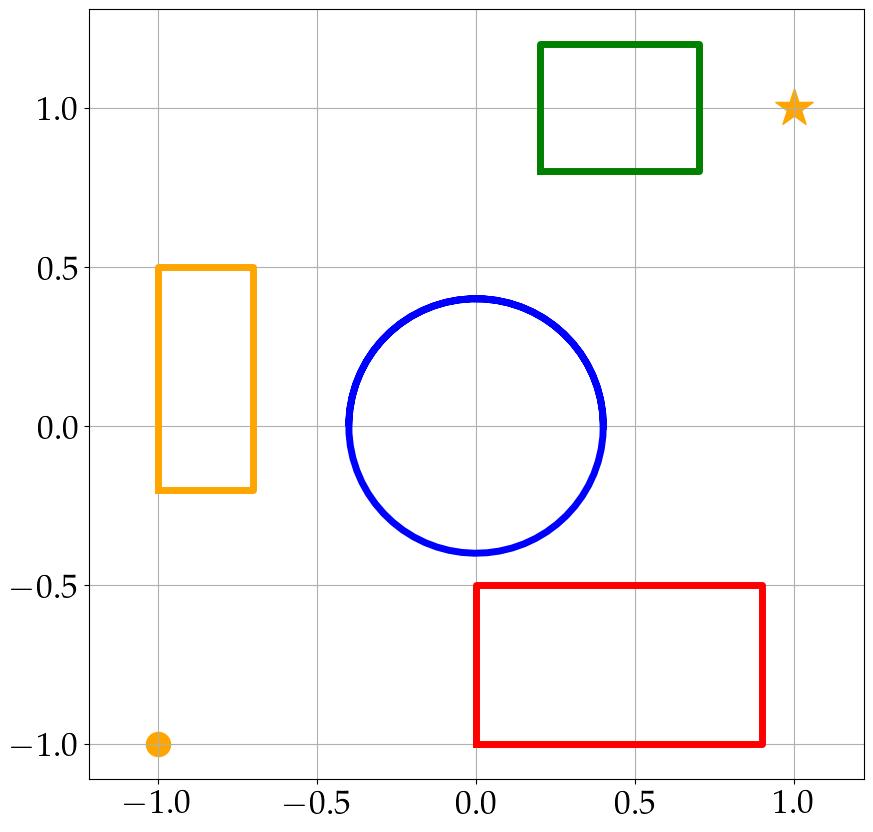

In [4]:
# plot the environment given the obstacles
plt.figure(figsize=(10,10))
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

plt.scatter([-1], [-1], s=300, c="orange")
plt.scatter([1], [1], s=800, marker='*', c="orange")
plt.axis("equal")
plt.grid()



### Constructing the STL formulas

In [5]:
def inside_box(xy, obs):
    x = stlcg.Expression('x', xy[:,:1].unsqueeze(0))
    y = stlcg.Expression('y', xy[:,1:].unsqueeze(0))
    r1 = stlcg.Expression('x1', obs[:1].unsqueeze(-1).unsqueeze(-1))
    r2 = stlcg.Expression('x2', obs[1:2].unsqueeze(-1).unsqueeze(-1))
    r3 = stlcg.Expression('y1', obs[2:3].unsqueeze(-1).unsqueeze(-1))
    r4 = stlcg.Expression('y2', obs[3:4].unsqueeze(-1).unsqueeze(-1))
    inputs = ((x,x), (y,y))
    return ((x > r1) & (x < r2)) & ((y > r3) & (y < r4)), inputs
#     ϕ1 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box, interval=[0,3]), interval=[0, 12])

def always_stay_outside_circle(xy, obs):
    d1 = stlcg.Expression('d1', torch.norm(xy - obs[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0))
    r1 = stlcg.Expression('r', obs[2:3].unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(d1 > r1)), d1

def control_limit(u, u_max):
    u_abs = stlcg.Expression('u', u.norm(dim=1, keepdim=True).unsqueeze(0))
    um = stlcg.Expression('umax', u_max.unsqueeze(-1).unsqueeze(-1))
    return stlcg.Always(subformula=(u_abs < um)), u_abs

### initializing solution $z$ as a straight line

In [6]:
dx = 0.04
n = np.stack([np.arange(-1, 1, dx), np.arange(-1, 1, dx)]).T
x0 = -np.ones(2)
xf = np.ones(2)
N = n.shape
u_max = torch.as_tensor(0.8).float()       # u max

### Setting up linear dynamics matrices

$x_{t+1} = Ax_t + Bu_t$, wher $A = I$, and $B = \Delta t\cdot I$. 

$Z = (x,u)$ (i.e., concatenating $x$ and $u$

$E$ represents a massive matrix that computes $Ax_t+ Bu_t - x_{t+1}$ and $d$ represents what it should equal to over each time step.

The last 4 rows of $E$ and last 4 elements of $d$ correspond to the end point constraints.

Slightly convoluted way to get a initial straight line guess. but oh well

In [7]:
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
E = np.zeros([2*(N[0]+1), (2*N[0] - 1)*N[1]])
d = np.zeros((2*(N[0]+1)))

for i in range(N[0]-1):
    E[2*i:2*i+2,2*i:2*i+2] = A
    E[2*i:2*i+2,2*(i+1):2*(i+1)+2] = -A
    j = 2*i + N[0]*N[1]
    E[2*i:2*i+2,j:j+2] = B
E[2*(N[0]-1):2*(N[0]-1)+2, :2] = A
E[2*N[0]:2*N[0]+2, 2*(N[0]-1):2*(N[0]-1)+2] = A

d[-4:-2] = x0
d[-2:] = xf

Q = np.zeros([(2*N[0] - 1)*N[1], (2*N[0] - 1)*N[1]])           # no state cost
R = np.eye((N[0]-1) * N[1])                                    # control cost
Q[N[1]*N[0]:, N[1]*N[0]:] = R
c = np.zeros([(2*N[0] - 1)*N[1]])

# building up the KKT matrix
K = np.zeros([Q.shape[0]+E.shape[0], Q.shape[1] + E.shape[0]])
K[:Q.shape[0], :] = np.concatenate([Q, E.T], axis=1)
K[Q.shape[0]:, :E.shape[1]] = E
D = np.concatenate([-c, d])

KK = torch.as_tensor(K).float()
DD = torch.as_tensor(D).float()

# matrix describing the dynamics and state constraints
CC = torch.as_tensor(d).float()
EE = torch.as_tensor(E).float()

# solving the KKT matrix (i.e., straight line) and getting only the states (not the lagrange multipliers)
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)


In [8]:
!mkdir -p figs/motion_planning

In [9]:
save_fig = True
fig_path = 'figs/motion_planning'

In [10]:
margin = 0.05 # can add a margin so things are not right on the boundary
T = 5
γ = 0.3
lr = 0.05
keepdim = True

### Constructing  $\phi_1 = \lozenge\,\square_{[0,5]} \text{inside red box} \: \wedge \: \lozenge \, \square_{[0, 5]} \text{inside green box} \: \wedge \: \square \, \neg\text{inside blue circle}$ 


In [11]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)
X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
ux = U[:,:1]
uy = U[:,1:]

In [12]:
inside_box_1, _ = inside_box(X, obs_1)  # ((x,x), (y,y))
inside_box_2, _ = inside_box(X, obs_2)  # ((x,x), (y,y))

has_been_inside_box_1 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_1, interval=[0,T]))
has_been_inside_box_2 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_2, interval=[0,T]))
always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ = (has_been_inside_box_1 & has_been_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

In [13]:
Z.retain_grad()

for _ in range(100):
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
    x = X[:,:1].unsqueeze(0)
    y = X[:,1:].unsqueeze(0)

    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

    robustness_eventually_in_one_region = torch.relu(-(has_been_inside_box_1.robustness(box_inputs, scale=-1).squeeze() - margin))
    # robustness_regions = torch.relu(-(ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze() - margin))
    # robustness_control = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())
    robustness_control = torch.tensor(999)
    
    # robustness = robustness_regions # + robustness_control
    robustness_regions = robustness_eventually_in_one_region
    robustness = robustness_regions
    
    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr * Z.grad
    
    if _ % 100 == 0:
        #x_saved_grad = x.grad.clone()
        #y_saved_grad = y.grad.clone()
        Z_saved_grad = Z.grad.clone()
        
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue", zorder=10)
        plt.grid()
        if save_fig:
            plt.savefig(fig_path + "/phi1_margin=" + str(margin) + "_" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_regions: %.3f    robustness_control: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_regions.detach().numpy(),  robustness_control.detach().numpy(), cont.detach().numpy()))

        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.122   robustness_regions: 0.407    robustness_control: 999.000     cont: 0.000000


In [14]:
np.save("models/phi1_margin=" + str(margin), Z.detach().numpy())

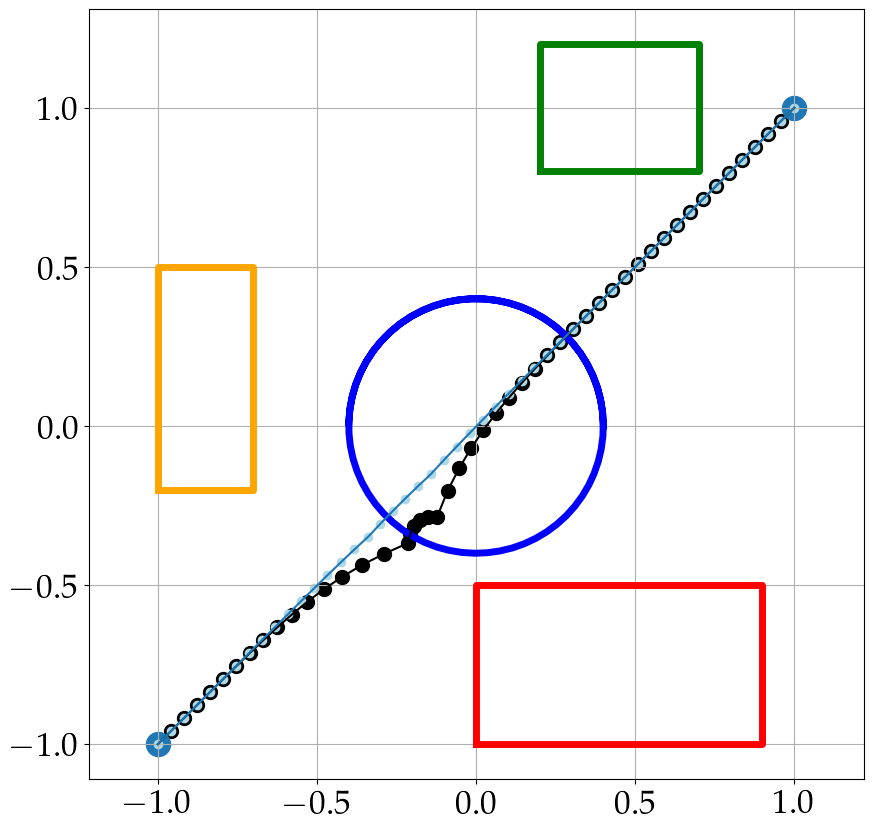

In [15]:
# plotting results
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])

plt.figure(figsize=(10,10))
# plotting environment
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

# plottign optimization results
plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
plt.scatter([-1,1], [-1,1], s=300)
plt.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u.detach().numpy()
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1])
plt.scatter(xs[:,0], xs[:,1], c="lightblue")
plt.grid()

In [16]:
# Z_saved_grad
Z.shape

torch.Size([198])

### Constructing  $\psi_1 = \lozenge\,Int{[0,5]} \text{inside red box} \: \wedge \: \lozenge \, Int{[0, 5]} \text{inside green box} \: \wedge \: \square \, \neg\text{inside blue circle}$ 

In [69]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)
X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
ux = U[:,:1]
uy = U[:,1:]

In [70]:
inside_box_1, _ = inside_box(X, obs_1)  # ((x,x), (y,y))
inside_box_2, _ = inside_box(X, obs_2)  # ((x,x), (y,y))

has_been_inside_box_1 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_1, interval=[0,T]))
has_been_inside_box_2 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_2, interval=[0,T]))
always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ = (has_been_inside_box_1 & has_been_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

In [71]:
for _ in range(5000):
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
    x = X[:,:1].unsqueeze(0)
    y = X[:,1:].unsqueeze(0)

    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    #robustness_regions = torch.relu(-(ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze() - margin))
    robustness_regions = torch.relu(-(has_been_inside_box_1.robustness(box_inputs, scale=-1).squeeze() - margin))
    robustness_control = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())

    robustness = robustness_regions # + robustness_control

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr * Z.grad
    
    if _ % 100 == 0:
        Z_grad = Z.grad.numpy()
        xy_grad = Z_grad[:N[0]*N[1]].reshape(N[0],N[1])
        
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)

        plt.quiver(xy.detach().numpy()[:, 0], xy.detach().numpy()[:, 1], xy_grad[:, 0], xy_grad[:, 1])
        
        plt.axis("equal")

        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue", zorder=10)
        plt.grid()
        if save_fig:
            plt.savefig(fig_path + "/psi1_margin=" + str(margin) + "_" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_regions: %.3f    robustness_control: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_regions.detach().numpy(),  robustness_control.detach().numpy(), cont.detach().numpy()))

        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.575   robustness_regions: 1.917    robustness_control: 0.000     cont: 0.000000
100: loss: 0.048   robustness_regions: 0.015    robustness_control: 0.000     cont: 0.043879
200: loss: 0.026   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.025580
300: loss: 0.017   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.017099
400: loss: 0.012   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.012288
500: loss: 0.009   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.009201
600: loss: 0.008   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.007827
700: loss: 0.006   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.005543
800: loss: 0.005   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.004825
900: loss: 0.004   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.004002
1000: loss: 0.003   robustness_regions: 0.000    robustness_control: 0.0

In [72]:
# help(plt.quiver)
# Z.grad.numpy()
xy_grad

array([[ 5.24520874e-06, -4.76837158e-06],
       [ 6.31809235e-06, -5.48362732e-06],
       [ 7.62939453e-06, -6.67572021e-06],
       [ 8.82148743e-06, -7.51018524e-06],
       [ 1.01327896e-05, -8.82148743e-06],
       [ 1.10864639e-05, -1.01327896e-05],
       [ 1.25169754e-05, -1.10864639e-05],
       [ 1.34706497e-05, -1.14440918e-05],
       [ 1.46627426e-05, -1.25169754e-05],
       [ 1.51991844e-05, -1.35898590e-05],
       [ 1.62124634e-05, -1.46627426e-05],
       [ 1.68681145e-05, -1.49011612e-05],
       [ 1.74343586e-05, -1.59740448e-05],
       [ 1.79111958e-05, -1.63316727e-05],
       [ 1.82986259e-05, -1.72853470e-05],
       [ 1.85668468e-05, -1.74045563e-05],
       [ 1.87195837e-05, -1.81198120e-05],
       [ 1.87419355e-05, -1.83582306e-05],
       [ 1.86562538e-05, -1.85966492e-05],
       [ 1.85221434e-05, -1.84774399e-05],
       [ 1.82092190e-05, -1.85966492e-05],
       [ 1.78366899e-05, -1.87158585e-05],
       [ 1.73747540e-05, -1.82986259e-05],
       [ 1.

In [73]:
np.save("models/psi1_margin="+str(margin), Z.detach().numpy())

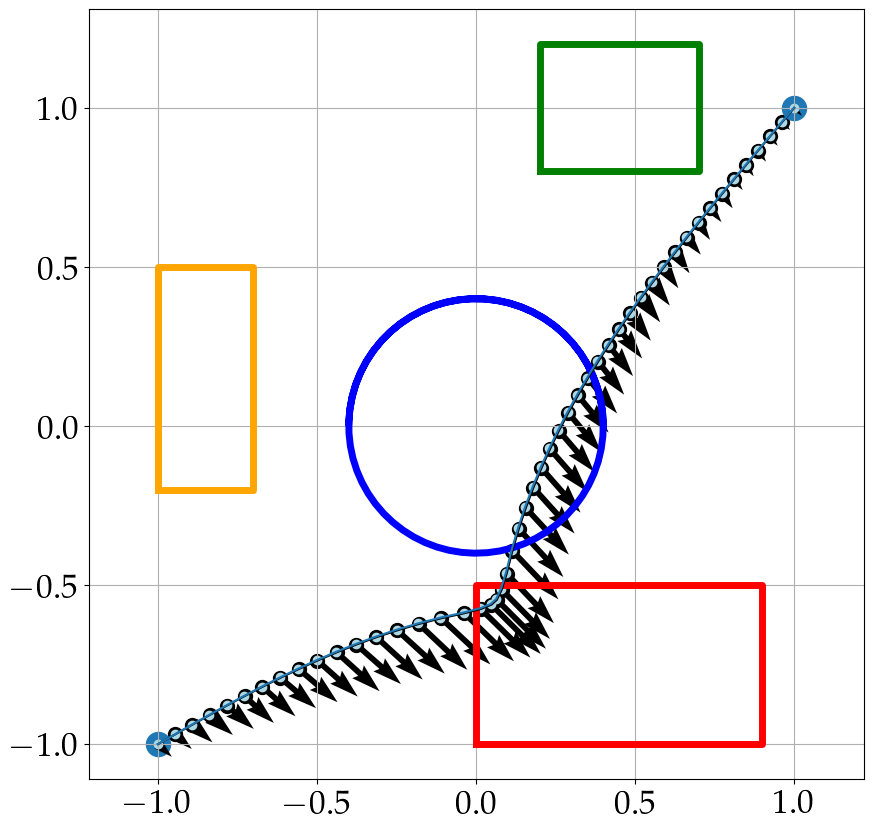

In [74]:
# plotting results
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])

plt.figure(figsize=(10,10))
# plotting environment
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

# plottign optimization results
plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
plt.scatter([-1,1], [-1,1], s=300)
plt.quiver(xy.detach().numpy()[:, 0], xy.detach().numpy()[:, 1], xy_grad[:, 0], xy_grad[:, 1])
plt.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u.detach().numpy()
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1])
plt.scatter(xs[:,0], xs[:,1], c="lightblue")
plt.grid()

### Constructing  $\phi_2 = \lozenge\,\square_{[0,5]} \text{inside orange box} \: \wedge \: \square \neg\text{inside green box} \: \wedge \:  \square \, \neg\text{inside blue circle}$ 

In [25]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)
X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
ux = U[:,:1]
uy = U[:,1:]

In [26]:
inside_box_4, _ = inside_box(X, obs_4)       # ((x,x), (y,y))
inside_box_2, _ = inside_box(X, obs_2)       # ((x,x), (y,y))

has_been_inside_box_4 = stlcg.Eventually(subformula=stlcg.Always(subformula=inside_box_4, interval=[0,T]))
never_inside_box_2 = stlcg.Always(subformula=~inside_box_2)
always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ = (has_been_inside_box_4 & never_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

In [27]:
for _ in range(5000):
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
    x = X[:,:1].unsqueeze(0)
    y = X[:,1:].unsqueeze(0)

    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    robustness_regions = torch.relu(-(ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze() - margin))
    robustness_control = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())

    robustness = robustness_regions + robustness_control

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr * Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue", zorder=10)
        plt.grid()
        if save_fig:
            plt.savefig(fig_path + "/phi2_margin=" + str(margin) + "_" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_regions: %.3f    robustness_control: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_regions.detach().numpy(),  robustness_control.detach().numpy(), cont.detach().numpy()))

        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.126   robustness_regions: 0.421    robustness_control: 0.000     cont: 0.000000
100: loss: 0.122   robustness_regions: 0.392    robustness_control: 0.000     cont: 0.004564
200: loss: 0.110   robustness_regions: 0.349    robustness_control: 0.000     cont: 0.005420
300: loss: 0.098   robustness_regions: 0.300    robustness_control: 0.000     cont: 0.007834
400: loss: 0.086   robustness_regions: 0.258    robustness_control: 0.000     cont: 0.008602
500: loss: 0.076   robustness_regions: 0.219    robustness_control: 0.000     cont: 0.010257
600: loss: 0.067   robustness_regions: 0.186    robustness_control: 0.000     cont: 0.011051
700: loss: 0.058   robustness_regions: 0.155    robustness_control: 0.000     cont: 0.011562
800: loss: 0.048   robustness_regions: 0.117    robustness_control: 0.000     cont: 0.012834
900: loss: 0.039   robustness_regions: 0.088    robustness_control: 0.000     cont: 0.012876
1000: loss: 0.031   robustness_regions: 0.058    robustness_control: 0.0

In [28]:
np.save("models/phi2_margin="+str(margin), Z.detach().numpy())

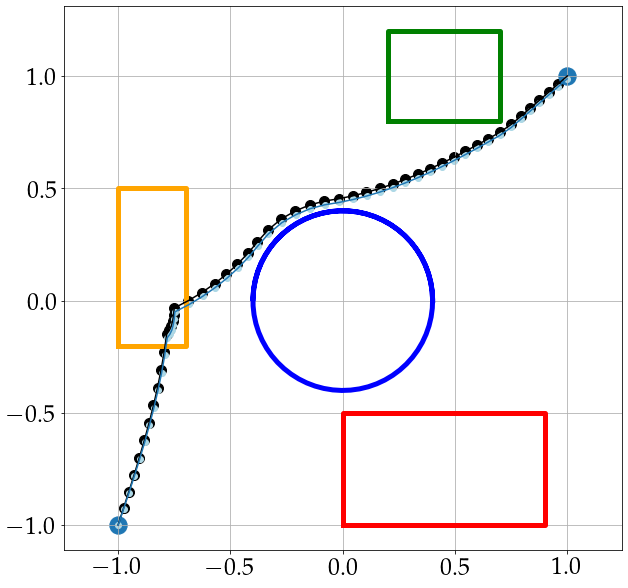

In [29]:
# plotting results
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])

plt.figure(figsize=(10,10))
# plotting environment
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

# plottign optimization results
plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
plt.scatter([-1,1], [-1,1], s=300)
plt.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u.detach().numpy()
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1])
plt.scatter(xs[:,0], xs[:,1], c="lightblue")
plt.grid()

### Constructing  $\psi_2 = \lozenge\,Int{[0,5]} \text{inside orange box} \: \wedge \: \square \neg \text{inside green box} \: \wedge \:  \square \, \neg \text{inside blue circle}$ 


In [30]:
Z = torch.as_tensor((np.linalg.inv(K) @ D)[:(2*N[0] - 1) * N[1]]).float().requires_grad_(True)
X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
x = X[:,:1].unsqueeze(0)
y = X[:,1:].unsqueeze(0)

U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
ux = U[:,:1]
uy = U[:,1:]

In [31]:
inside_box_4, _ = inside_box(X, obs_4)       # ((x,x), (y,y))
inside_box_2, _ = inside_box(X, obs_2)       # ((x,x), (y,y))

has_been_inside_box_4 = stlcg.Eventually(subformula=stlcg.Integral1d(subformula=inside_box_4, interval=[0,T]))
never_inside_box_2 = stlcg.Always(subformula=~inside_box_2)
always_stay_outside_circle_formula, _ = always_stay_outside_circle(X, obs_3)

ϕ = (has_been_inside_box_4 & never_inside_box_2) & always_stay_outside_circle_formula
θ, _ = control_limit(U, u_max)

box_inputs = ((x, x),(y, y))
circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)

robustness_1 = torch.relu(-ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze())
robustness_2 = torch.relu(-θ.robustness(control_inputs, scale=-1).squeeze())

In [32]:
for _ in range(5000):
    X = Z[:N[0]*N[1]].reshape(N[0], N[1])  # first bit of Z
    x = X[:,:1].unsqueeze(0)
    y = X[:,1:].unsqueeze(0)

    U = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1])].reshape(N[0]-1,N[1])  # last bit of Z
    ux = U[:,:1]
    uy = U[:,1:]
    
    box_inputs = ((x, x),(y, y)) # changes as Z changes (points to the Z tensor)
    circle_inputs = torch.norm(X - obs_3[:2].unsqueeze(0), dim=-1, keepdim=True).unsqueeze(0)
    control_inputs = U.norm(dim=1, keepdim=True).unsqueeze(0)
    
    robustness_regions = torch.relu(-(ϕ.robustness(((box_inputs, box_inputs), circle_inputs), scale=-1).squeeze() - margin))
    robustness_control = torch.relu(-θ.robustness(control_inputs, scale=-1, keepdim=keepdim).squeeze())

    robustness = robustness_regions + robustness_control

    cont = (torch.matmul(EE, Z) - CC).pow(2).sum()
    
    loss = cont + γ*robustness 
    loss.backward()
    with torch.no_grad():
        Z -= lr * Z.grad
    
    if _ % 100 == 0:
        xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
        u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
        # plt.scatter(past.detach().numpy()[:,0], past.detach().numpy()[:,1])
        plt.figure(figsize=(10,10))
        plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
        plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
        plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)

        plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

        plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
        plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
        plt.scatter([-1,1], [-1,1], s=300)
        plt.axis("equal")


        xs = [x0]
        us = u.detach().numpy()
        for i in range(49):
            x_next = A @ xs[i] + B @ us[i]
            xs.append(x_next)
        xs = np.stack(xs)
        plt.plot(xs[:,0], xs[:,1])
        plt.scatter(xs[:,0], xs[:,1], c="lightblue", zorder=10)
        plt.grid()
        if save_fig:
            plt.savefig(fig_path + "/psi2_margin=" + str(margin) + "_" + str(_).rjust(4, '0') + ".png")
        print("%i: loss: %.3f   robustness_regions: %.3f    robustness_control: %.3f     cont: %.6f"%(_, loss.detach().numpy(), robustness_regions.detach().numpy(),  robustness_control.detach().numpy(), cont.detach().numpy()))

        plt.close()
    if (robustness < 1E-2) & (cont < 1E-6):
        print("FINISHED!")
        break
    Z.grad.zero_()

0: loss: 0.575   robustness_regions: 1.917    robustness_control: 0.000     cont: 0.000000
100: loss: 0.147   robustness_regions: 0.382    robustness_control: 0.000     cont: 0.032289
200: loss: 0.096   robustness_regions: 0.235    robustness_control: 0.000     cont: 0.024917
300: loss: 0.064   robustness_regions: 0.138    robustness_control: 0.000     cont: 0.022985
400: loss: 0.038   robustness_regions: 0.057    robustness_control: 0.000     cont: 0.021156
500: loss: 0.018   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.017924
600: loss: 0.012   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.012204
700: loss: 0.010   robustness_regions: 0.001    robustness_control: 0.000     cont: 0.009703
800: loss: 0.008   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.007541
900: loss: 0.006   robustness_regions: 0.000    robustness_control: 0.000     cont: 0.006107
1000: loss: 0.005   robustness_regions: 0.000    robustness_control: 0.0

In [33]:
np.save("models/psi2_margin="+str(margin), Z.detach().numpy())

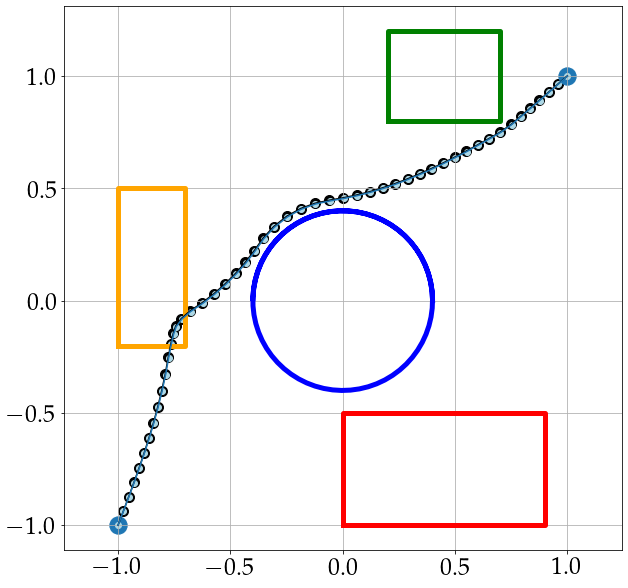

In [34]:
# plotting results
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])

plt.figure(figsize=(10,10))
# plotting environment
plt.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
plt.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
plt.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
plt.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

# plottign optimization results
plt.plot(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black")
plt.scatter(xy.detach().numpy()[:,0], xy.detach().numpy()[:,1], c="black", s=100)
plt.scatter([-1,1], [-1,1], s=300)
plt.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u.detach().numpy()
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
plt.plot(xs[:,0], xs[:,1])
plt.scatter(xs[:,0], xs[:,1], c="lightblue")
plt.grid()

# Plotting combined plot (always operator)

In [35]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

linewidth = 10
markersize = 50
fontsize = 24

In [36]:

obs_1 = torch.tensor([0.0, 0.9, -1.0, -0.5]).float()
obs_2 = torch.tensor([.2, 0.7, 0.8, 1.2]).float()
obs_3 = torch.tensor([0.0, 0.0, 0.4]).float()
obs_4 = torch.tensor([-1.0, -0.7, -0.2, 0.5]).float()

x0 = -np.ones(2)
xf = np.ones(2)
Δt = 0.1
A = np.eye(2)
B = np.eye(2) * Δt
u_max = torch.as_tensor(0.8).float()

ts = np.arange(0, 5, Δt)

In [37]:
margin = 0.05

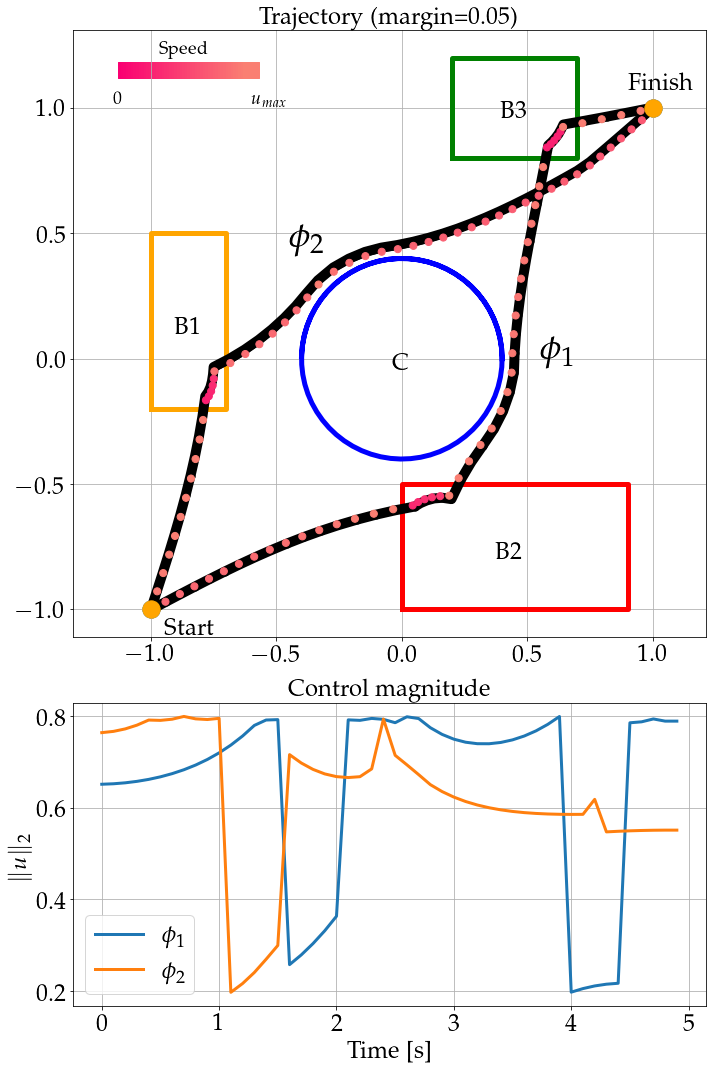

In [38]:
# plotting results

fig, axs = plt.subplots(2,1, figsize=(10,15), gridspec_kw={'height_ratios': [2,1]})
ax1 = axs[0]
ax2 = axs[1]

# plotting environment
ax1.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
ax1.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
ax1.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
ax1.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

Z = np.load("models/phi1_margin="+str(margin)+'.npy')
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

ax2.plot(ts, u_norm, label="$\phi_1$", linewidth=3)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

# plotting optimization results
ax1.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)
ax1.scatter(xy[:,0], xy[:,1], c="black", s=markersize)
ax1.scatter([-1,1], [-1,1], s=300, zorder=10, c="orange")
ax1.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
ax1.plot(xs[:,0], xs[:,1], "black")
ax1.scatter(xs[:,0], xs[:,1], zorder=3, color=colors, s=markersize)

Z = np.load("models/phi2_margin="+str(margin)+'.npy')
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

ax2.plot(ts, u_norm, label="$\phi_2$", linewidth=3)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

# plotting optimization results
ax1.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)
ax1.scatter(xy[:,0], xy[:,1], c="black", s=markersize)
ax1.scatter([-1,1], [-1,1], s=300)
ax1.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
ax1.plot(xs[:,0], xs[:,1], "black")
ax1.scatter(xs[:,0], xs[:,1], zorder=3, color=colors, s=markersize)


ax1.grid()
ax2.grid()

ax1.set_title("Trajectory (margin=%.2f)"%margin, fontsize=fontsize)

ax2.set_title("Control magnitude", fontsize=fontsize)
ax2.legend(fontsize=fontsize)
ax2.set_ylabel("$\|u\|_2$", fontsize=fontsize)
ax2.set_xlabel("Time [s]", fontsize=fontsize)

ax1.text(-0.95, -1.1, "Start", fontsize=24)
ax1.text(0.9, 1.07, "Finish", fontsize=24)

ax1.text(0.55, 0.0, "$\phi_1$", fontsize=36)
ax1.text(-0.45, 0.45, "$\phi_2$", fontsize=36)
ax1.text(-0.97, 1.22, "Speed", fontsize=18)
ax1.text(-1.15, 1.02, "0", fontsize=18)
ax1.text(-0.6, 1.02, "$u_{max}$", fontsize=18)

ax1.text(-0.91, 0.1, "B1", fontsize=24)
ax1.text(0.37, -0.8, "B2", fontsize=24)
ax1.text(0.39, 0.96, "B3", fontsize=24)
ax1.text(-0.04, -0.04, "C", fontsize=24)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* np.arange(50)/49
ax1.scatter(np.arange(50)/49/2 - 1.1, 1.15*np.ones(50), color=colors, s=250, marker='s')
plt.tight_layout()

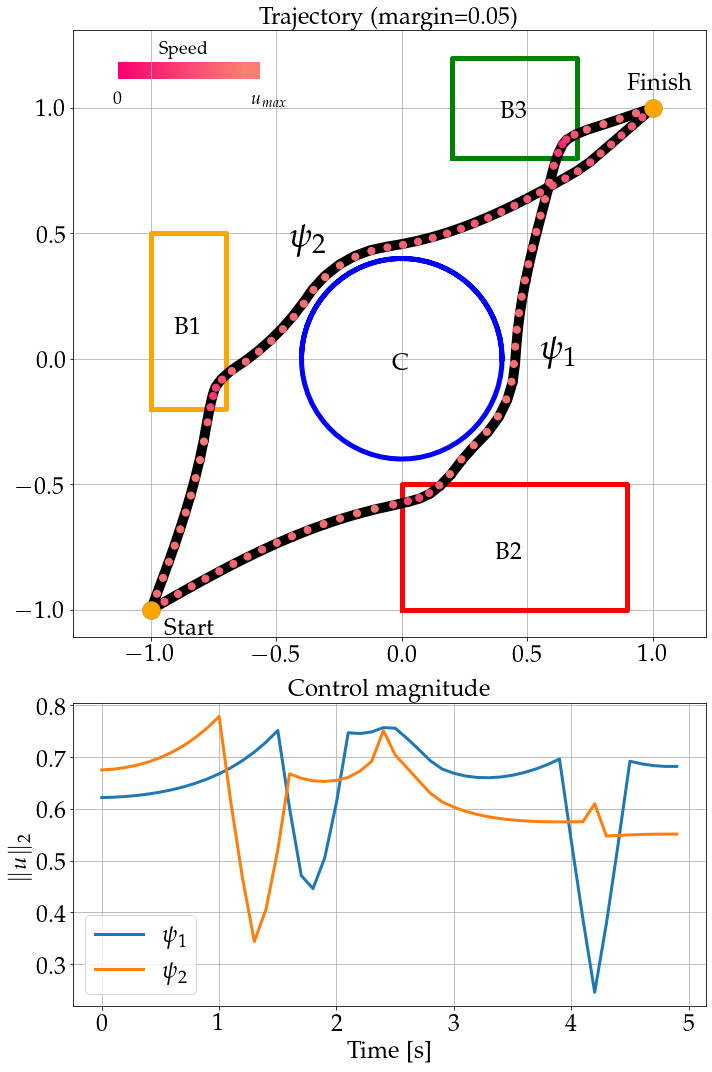

In [39]:
# plotting results

fig, axs = plt.subplots(2,1, figsize=(10,15), gridspec_kw={'height_ratios': [2,1]})
ax1 = axs[0]
ax2 = axs[1]

# plotting environment
ax1.plot([obs_1[0], obs_1[0], obs_1[1], obs_1[1], obs_1[0]], [obs_1[2], obs_1[3], obs_1[3], obs_1[2], obs_1[2]], c="red", linewidth=5)
ax1.plot([obs_2[0], obs_2[0], obs_2[1], obs_2[1], obs_2[0]], [obs_2[2], obs_2[3], obs_2[3], obs_2[2], obs_2[2]], c="green", linewidth=5)
ax1.plot([obs_4[0], obs_4[0], obs_4[1], obs_4[1], obs_4[0]], [obs_4[2], obs_4[3], obs_4[3], obs_4[2], obs_4[2]], c="orange", linewidth=5)
ax1.plot([obs_3[0] + obs_3[2].numpy()*np.cos(t) for t in np.arange(0,3*np.pi,0.1)], [obs_3[1] + obs_3[2].numpy()*np.sin(t) for t in np.arange(0,3*np.pi,0.1)], c="blue", linewidth=5)

Z = np.load("models/psi1_margin="+str(margin)+'.npy')
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

ax2.plot(ts, u_norm, label="$\psi_1$", linewidth=3)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

# plotting optimization results
ax1.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)
ax1.scatter(xy[:,0], xy[:,1], c="black", s=markersize)
ax1.scatter([-1,1], [-1,1], s=300, zorder=10, c="orange")
ax1.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
ax1.plot(xs[:,0], xs[:,1], "black")
ax1.scatter(xs[:,0], xs[:,1], zorder=3, color=colors, s=markersize)

Z = np.load("models/psi2_margin="+str(margin)+'.npy')
xy = Z[:N[0]*N[1]].reshape(N[0],N[1])
u = Z[N[0]*N[1]:(N[0]*N[1] + (N[0]-1)*N[1]) ].reshape(N[0]-1,N[1])
u_norm = np.sqrt(np.sum(u**2, axis=1))
u_norm = np.concatenate([u_norm, [u_norm[-1]]], axis=-1)
alpha = u_norm/u_max.numpy()

ax2.plot(ts, u_norm, label="$\psi_2$", linewidth=3)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* (alpha)

# plotting optimization results
ax1.plot(xy[:,0], xy[:,1], c="black", linewidth=linewidth)
ax1.scatter(xy[:,0], xy[:,1], c="black", s=markersize)
ax1.scatter([-1,1], [-1,1], s=300)
ax1.axis("equal")

# plotting states from simulating controls
xs = [x0]
us = u
for i in range(49):
    x_next = A @ xs[i] + B @ us[i]
    xs.append(x_next)
xs = np.stack(xs)
ax1.plot(xs[:,0], xs[:,1], "black")
ax1.scatter(xs[:,0], xs[:,1], zorder=3, color=colors, s=markersize)


ax1.grid()
ax2.grid()

ax1.set_title("Trajectory (margin=%.2f)"%margin, fontsize=fontsize)

ax2.set_title("Control magnitude", fontsize=fontsize)
ax2.legend(fontsize=fontsize)
ax2.set_ylabel("$\|u\|_2$", fontsize=fontsize)
ax2.set_xlabel("Time [s]", fontsize=fontsize)

ax1.text(-0.95, -1.1, "Start", fontsize=24)
ax1.text(0.9, 1.07, "Finish", fontsize=24)

ax1.text(0.55, 0.0, "$\psi_1$", fontsize=36)
ax1.text(-0.45, 0.45, "$\psi_2$", fontsize=36)
ax1.text(-0.97, 1.22, "Speed", fontsize=18)
ax1.text(-1.15, 1.02, "0", fontsize=18)
ax1.text(-0.6, 1.02, "$u_{max}$", fontsize=18)

ax1.text(-0.91, 0.1, "B1", fontsize=24)
ax1.text(0.37, -0.8, "B2", fontsize=24)
ax1.text(0.39, 0.96, "B3", fontsize=24)
ax1.text(-0.04, -0.04, "C", fontsize=24)

colors = np.ones([50,4])
colors[:,:3] =  np.array([250, 128, 114])/255
colors[:,1] = (127/255)* np.arange(50)/49
ax1.scatter(np.arange(50)/49/2 - 1.1, 1.15*np.ones(50), color=colors, s=250, marker='s')
plt.tight_layout()